In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap
import joblib

# Téléchargez la liste de stop words en français
nltk.download('stopwords')
nltk.download('punkt')

# Importez la liste de stop words en français
from nltk.corpus import stopwords
stop_words_french = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
df_test = pd.read_csv("./df_featEngin.csv")
df_test.head(10)

,index,Nombre_avis_publie,Note,Titres,Commentaire,Verifications,longCommentaire,longTitres,nb_Mots_Commentaire,nb_Mots_Titres,...,Titres_3grame_livraison_trop_longue,Titres_3grame_delai_livraison_trop,Titres_3grame_rapport_qualite_prix,Titres_3grame_livraison_rapide_conforme,Titres_3grame_livraison_peu_longue,Titres_3grame_livraison_rapide_prix,TextBlob_polarity_Commentaire,TextBlob_polarity_Titres,Saison_experience,Sentiment
0,0,1,5,Je commande mes pneus de motos et de voitures,Je commande mes pneus de motos et de voitures ...,1,215,45,31,9,...,0,0,0,0,0,0,0.271000,0.00,3,1
1,1,6,5,"Ne cherchez plus vos pneus, Allopneus le peut","BonjourLe site est genial, tres bien explique ...",1,315,45,48,8,...,0,0,0,0,0,0,0.400000,0.15,3,1
2,2,3,5,Tout etait parfait,"Tout etait parfait, timing parfait dans les da...",1,227,18,36,3,...,0,0,0,0,0,0,0.391667,0.51,3,1
3,3,4,5,Pneus d'un tres bon rapport qualite_,Pneus d'un tres bon rapport qualite prix. Les ...,1,157,36,22,6,...,0,0,0,0,0,0,0.607500,1.00,3,1
4,4,1,4,"Bon suivi de la commande,les questions_","Bon suivi de la commande,les questions sont im...",1,218,39,34,6,...,0,0,0,0,0,0,0.133333,0.70,3,1
5,5,1,5,"Excellent service, bien plus avantageux compar...",Ce service sur place est d un grand secours. R...,1,276,62,48,8,...,0,0,0,0,0,0,0.202083,0.21,3,1
6,6,1,5,commande jusqu'au montage,La commande sur internet c'est tres bien passe...,1,439,25,71,3,...,0,0,0,0,0,0,0.216923,0.00,3,1
7,7,4,5,Excellent,"RAS, le rapport qualite prix est tres correct....",1,217,9,39,1,...,0,0,0,0,0,0,0.367143,0.50,3,1
8,8,3,5,Fidele depuis de nombreuses annees j ai_,Fidele depuis de nombreuses annees j ai toujou...,1,112,40,19,7,...,0,0,0,0,0,0,0.282500,0.05,3,1
9,9,1,5,Meilleur rapport qualite prix,M'a ete recommande. Meilleur rapport qualite p...,1,183,29,30,4,...,0,0,1,0,0,0,0.207500,0.53,3,1


In [42]:
# (a) Supprimer les caractères spéciaux, chiffres, valeurs manquantes et mettre le texte en minuscules.
df_test['Commentaire'] = df_test['Commentaire'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_test['Commentaire'] = df_test['Commentaire'].fillna('') 
df_test['Titres'] = df_test['Titres'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_test['Titres'] = df_test['Titres'].fillna('') 
#df_test = df_test.drop(columns=[])
df_test.head(10)

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


,index,Nombre_avis_publie,Note,Titres,Commentaire,Verifications,longCommentaire,longTitres,nb_Mots_Commentaire,nb_Mots_Titres,...,Titres_3grame_livraison_trop_longue,Titres_3grame_delai_livraison_trop,Titres_3grame_rapport_qualite_prix,Titres_3grame_livraison_rapide_conforme,Titres_3grame_livraison_peu_longue,Titres_3grame_livraison_rapide_prix,TextBlob_polarity_Commentaire,TextBlob_polarity_Titres,Saison_experience,Sentiment
0,0,1,5,je commande mes pneus de motos et de voitures,je commande mes pneus de motos et de voitures ...,1,215,45,31,9,...,0,0,0,0,0,0,0.271000,0.00,3,1
1,1,6,5,ne cherchez plus vos pneus allopneus le peut,bonjourle site est genial tres bien explique p...,1,315,45,48,8,...,0,0,0,0,0,0,0.400000,0.15,3,1
2,2,3,5,tout etait parfait,tout etait parfait timing parfait dans les dat...,1,227,18,36,3,...,0,0,0,0,0,0,0.391667,0.51,3,1
3,3,4,5,pneus dun tres bon rapport qualite,pneus dun tres bon rapport qualite prix les me...,1,157,36,22,6,...,0,0,0,0,0,0,0.607500,1.00,3,1
4,4,1,4,bon suivi de la commandeles questions,bon suivi de la commandeles questions sont imm...,1,218,39,34,6,...,0,0,0,0,0,0,0.133333,0.70,3,1
5,5,1,5,excellent service bien plus avantageux compare...,ce service sur place est d un grand secours ri...,1,276,62,48,8,...,0,0,0,0,0,0,0.202083,0.21,3,1
6,6,1,5,commande jusquau montage,la commande sur internet cest tres bien passee...,1,439,25,71,3,...,0,0,0,0,0,0,0.216923,0.00,3,1
7,7,4,5,excellent,ras le rapport qualite prix est tres correct t...,1,217,9,39,1,...,0,0,0,0,0,0,0.367143,0.50,3,1
8,8,3,5,fidele depuis de nombreuses annees j ai,fidele depuis de nombreuses annees j ai toujou...,1,112,40,19,7,...,0,0,0,0,0,0,0.282500,0.05,3,1
9,9,1,5,meilleur rapport qualite prix,ma ete recommande meilleur rapport qualite pri...,1,183,29,30,4,...,0,0,1,0,0,0,0.207500,0.53,3,1


In [4]:
from gensim.models import FastText

# Replace 'path/to/pretrained/embeddings' with the actual path to your downloaded embeddings file
model_Ft = FastText.load_fasttext_format("FastText/cc.fr.300.bin.gz")

Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).


In [43]:
# Define preprocessing function
stop_words = set(stopwords.words('french'))

def preprocess_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Apply FastText embeddings to each element in the Series
def get_text_embedding(text):
    preprocessed_text = preprocess_text(text)
    word_embeddings = [model_Ft.wv[word] for word in preprocessed_text if word in model_Ft.wv.key_to_index]
    
    if word_embeddings:
        text_embedding = np.mean(word_embeddings, axis=0)  # Use mean for aggregation
    else:
        text_embedding = np.zeros(model_Ft.vector_size)  # Use zero vector if no embeddings found
    
    return text_embedding


In [44]:
# Create a new column 'embedding' with the text embeddings
df_test['embedding_Commentaire'] = df_test['Commentaire'].apply(get_text_embedding)
df_test['embedding_Titres'] = df_test['Titres'].apply(get_text_embedding)

In [45]:
df_expanded = df_test['embedding_Commentaire'].apply(lambda x: pd.Series(x, dtype="float64")).add_prefix('vectComment_')
df_test = pd.concat([df_test, df_expanded], axis=1)
df_test = df_test.drop('embedding_Commentaire', axis=1)

df_expanded2 = df_test['embedding_Titres'].apply(lambda x: pd.Series(x, dtype="float64")).add_prefix('vectTitre_')
df_test = pd.concat([df_test, df_expanded2], axis=1)
df_test = df_test.drop('embedding_Titres', axis=1)


In [46]:
print(df_test.info())

#print(X_train.tolist()[0:5])
#print([x for x in X_train.apply(lambda x: len(x)) if x != 300])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285983 entries, 0 to 285982
Columns: 671 entries, index to vectTitre_299
dtypes: float64(602), int64(67), object(2)
memory usage: 1.4+ GB
None


In [47]:

df = df_test.filter(like = 'vect')
                    
df = pd.concat([df,df_test[['Nombre_avis_publie','longCommentaire','longTitres','nb_Mots_Commentaire','nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre', 'Sentiment']]],axis=1)
                                
                    
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285983 entries, 0 to 285982
Columns: 614 entries, vectComment_0 to Sentiment
dtypes: float64(600), int64(14)
memory usage: 1.3 GB
None
   vectComment_0  vectComment_1  vectComment_2  vectComment_3  vectComment_4  \
0       0.011306       0.016411      -0.017874      -0.011596      -0.065694   
1       0.019220       0.009953      -0.026793      -0.008516      -0.085727   
2       0.014238       0.001802      -0.016503       0.002777      -0.093255   
3       0.008320      -0.009746      -0.042637      -0.001757      -0.087079   
4       0.030223       0.006146      -0.021092      -0.012093      -0.062279   
5       0.014521       0.008975      -0.038061      -0.007624      -0.109386   
6       0.021570       0.008288      -0.027958       0.000285      -0.086603   
7       0.016658      -0.001761      -0.030290      -0.014614      -0.080752   
8      -0.004167       0.025591      -0.054842      -0.022558      -0.037973   
9       0.00960

In [34]:
df.to_csv('./Data/df_embedded.csv',index=False)

NameError: name 'df' is not defined

In [48]:
# (b) Division du DataFrame en ensembles d'entraînement et de test.

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Sentiment"), df['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train.to_csv('./Data/xTrain_embedded.csv',index=False)
X_test.to_csv('./Data/xTest_embedded.csv',index=False)
y_train.to_csv('./Data/yTrain_embedded.csv',index=False)
y_test.to_csv('./Data/yTest_embedded.csv',index=False)

## Random Forest:

In [ ]:
# (d) Création du classificateur RandomForest.

param_grid={'n_estimator':[100,200,500],'min_samples_split':[2,5,10],'min_samples_leaf':[1,5,10],'max_features':["auto", "sqrt", "log2"]}

for param1 in param_grid['n_estimator']:
    for param2 in param_grid['min_samples_split']:
        for param3 in param_grid['min_samples_leaf']:
            for param4 in param_grid['max_features']:
                clf = make_pipeline(StandardScaler(with_mean=False), RandomForestClassifier(n_estimators=param1,min_samples_split=param2,min_samples_leaf=param3,max_features=param4 , random_state=42))

                # (e) Entraînement du classificateur sur l'ensemble d'entraînement.
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                # (f) Affichage du rapport de classification du modèle Gradient Boosting.
                print("Rapport de classification :\n", classification_report(y_test, y_pred))

                # (g) Calcul et affichage de la matrice de confusion.
                confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
                print(confusion_matrix)
                
                filename = f'./dataBase_models/modelisation2_randFor_n_{param1}_minsamplessplit_{param2}_minsamplesleaf_{param3}_maxfeatures_{param4}.pkl'
                joblib.dump(clf, filename)
                
                

In [24]:
clf = joblib.load('dataBase_models/modelisation2_randFor_n_100_minsamplessplit_2_minsamplesleaf_1_maxfeatures_auto.pkl')

# (e) Entraînement du classificateur sur l'ensemble d'entraînement.

y_pred = clf.predict(X_test)

# (f) Affichage du rapport de classification du modèle Gradient Boosting.
print("Rapport de classification :\n", classification_report(y_test, y_pred))

# (g) Calcul et affichage de la matrice de confusion.
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(confusion_matrix)

Rapport de classification :
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     10645
           1       0.93      0.97      0.95     46552

    accuracy                           0.92     57197
   macro avg       0.89      0.83      0.85     57197
weighted avg       0.91      0.92      0.91     57197

Classe prédite     0      1
Classe réelle              
0               7366   3279
1               1412  45140


In [ ]:
# Identify the last step (XGBoost model) in the pipeline
model = clf.steps[-1][1]

# Create a SHAP explainer object using the XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate Shapley values for a specific instance
shap_values = explainer.shap_values(X_test)



['nb_Mots_Commentaire', 'longCommentaire', 'vectComment_217', 'nb_chiffres_Commentaire', 'vectComment_147', 'vectComment_56', 'vectComment_282', 'vectComment_169', 'vectTitre_202', 'vectComment_6', 'vectComment_59', 'vectComment_29', 'vectComment_219', 'vectComment_159', 'vectComment_97', 'vectComment_87', 'vectTitre_188', 'vectComment_21', 'vectComment_162', 'vectComment_286']


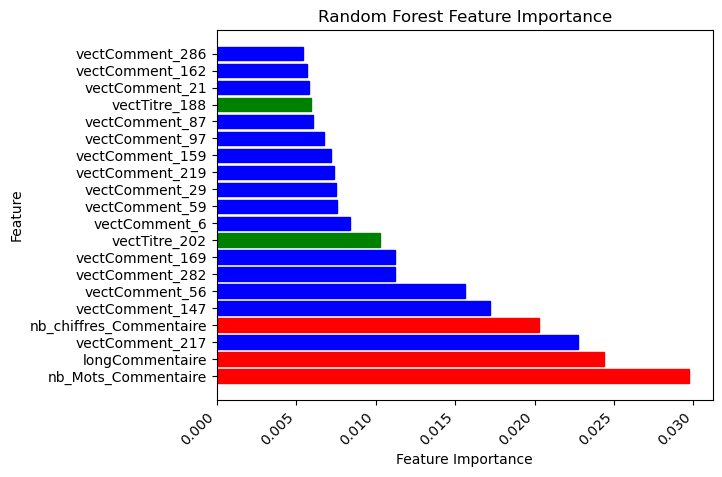

In [103]:
clf = joblib.load('dataBase_models/modelisation2_randFor_n_100_minsamplessplit_5_minsamplesleaf_1_maxfeatures_sqrt.pkl')


feature_importances = clf.steps[-1][1].feature_importances_


# Sort indices based on importance
sorted_indices = np.argsort(feature_importances)[::-1]

top_n = 20
top_indices = sorted_indices[:top_n]

# Plot feature importance
barlist = plt.barh(range(top_n), feature_importances[top_indices])
plt.yticks(range(top_n), X_train.columns[top_indices])
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45,ha='right')

top_features = X_train.columns[top_indices].to_list()
print(top_features)
for i in range(len(top_features)):
    if 'vectTitre_' in top_features[i]:
        barlist[i].set_color('g')
    elif 'vectComment_' in top_features[i]:
        barlist[i].set_color('b')
    else:
        barlist[i].set_color('r')
        
plt.show()

# XGBoost:

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'eval_metric':['logloss']#,'error','aucpr']
    
}

#grid_search = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, cv=3)
#grid_search.fit(X_train, y_train)


In [ ]:
best_params = grid_search.best_params_
best_clf_xgb = grid_search.best_estimator_
y_pred = best_clf_xgb.predict(X_test)

In [ ]:
print(best_params)

In [ ]:

filename = f'./dataBase_models/modelisation2_xgBoost_learningRate_{0.2}_maxDepth_{7}_nEstimators_{200}_evalMetric_error.pkl'
joblib.dump(best_clf_xgb, filename)

In [ ]:
for param1 in param_grid['max_depth']:
    for param2 in param_grid['learning_rate']:
        for param3 in param_grid['n_estimators']:
            for param4 in param_grid['eval_metric']:
                clf_xgb = xgb.XGBClassifier(objective='binary:logistic', eval_metric=param4, max_depth=param1, learning_rate=param2,n_estimators=param3)
                clf_xgb.fit(X_train, y_train)
                y_pred  = clf_xgb.predict(X_test)
                
                print("Accuracy:", accuracy_score(y_test, y_pred))
                print("\nClassification Report:\n", classification_report(y_test, y_pred))
                print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
                
                filename = f'./dataBase_models/modelisation2_xgBoost_learningRate_{param2}_maxDepth_{param1}_nEstimators_{param3}_evalMetric_{param4}.pkl'
                joblib.dump(best_clf_xgb, filename)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [105]:
clf = joblib.load('dataBase_models/modelisation2_xgBoost_learningRate_0.01_maxDepth_5_nEstimators_100_evalMetric_error.pkl')

# Create a SHAP explainer object using the XGBoost model
explainer = shap.TreeExplainer(clf)

# Calculate Shapley values for a specific instance
print(X_test.shape)
shap_values = explainer.shap_values(X_test.iloc[0])

(57197, 613)


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

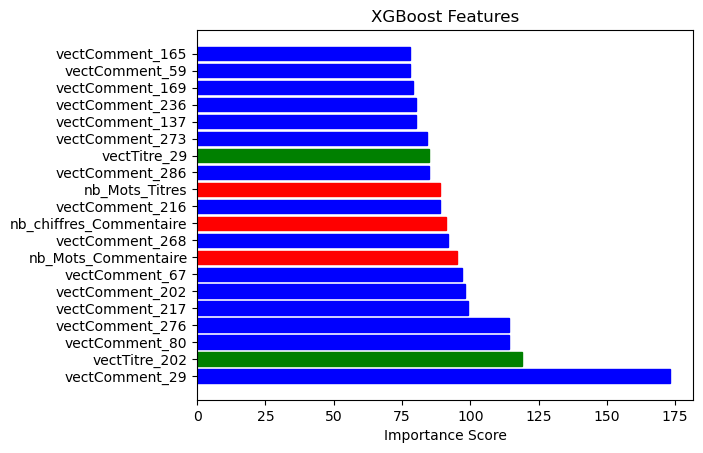

In [108]:
importance_scores = clf.get_booster().get_score(importance_type='weight')

features = list(importance_scores.keys())
importance_values = list(importance_scores.values())

sorted_indices = sorted(range(len(importance_values)), key=lambda k: importance_values[k], reverse=True)

top_n = 20
top_features = [features[i] for i in sorted_indices[:top_n]]
top_importance_values = [importance_values[i] for i in sorted_indices[:top_n]]


# Plot feature importance
barlist = plt.barh(top_features, top_importance_values)
plt.xlabel('Importance Score')
plt.title('XGBoost Features')

for i in range(len(top_features)):
    if 'vectTitre_' in top_features[i]:
        barlist[i].set_color('g')
    elif 'vectComment_' in top_features[i]:
        barlist[i].set_color('b')
    else:
        barlist[i].set_color('r')
    
plt.show()

### XGBoost 2: Note analysis

In [13]:
df2 = df_test.filter(like = 'vect')
                    
df2 = pd.concat([df2,df_test[['Nombre_avis_publie','longCommentaire','longTitres','nb_Mots_Commentaire','nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre', 'Note']]],axis=1)
                                
                    
print(df.info())
print(df.head(10))


X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns="Note"), df2['Note'], test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285983 entries, 0 to 285982
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Nombre_avis_publie          285983 non-null  int64
 1   longCommentaire             285983 non-null  int64
 2   longTitres                  285983 non-null  int64
 3   nb_Mots_Commentaire         285983 non-null  int64
 4   nb_Mots_Titres              285983 non-null  int64
 5   nb_majuscules_Commentaire   285983 non-null  int64
 6   nb_chiffres_Commentaire     285983 non-null  int64
 7   nb_ponctuation_Commentaire  285983 non-null  int64
 8   nb_special_Commentaire      285983 non-null  int64
 9   nb_majuscules_Titre         285983 non-null  int64
 10  nb_chiffres_Titre           285983 non-null  int64
 11  nb_ponctuation_Titre        285983 non-null  int64
 12  nb_special_Titre            285983 non-null  int64
 13  Sentiment                   285983 non-null 

In [17]:
clf_xgb = xgb.XGBClassifier(objective='multi:softmax', eval_metric={'mlogloss'}, nfold=5,num_classes=len(y_train.unique()))

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'eval_metric':['mlogloss']#,'error','aucpr'],    
}


grid_search = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train.map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}))



[18:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nfold", "num_classes" } are not used.

[18:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nfold", "num_classes" } are not used.

[18:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nfold", "num_classes" } are not used.

[18:55:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nfold", "num_classes" } are not used.



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric={'mlogloss'},
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...one, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nfold=5, num_classes=5, ...),
             param_grid={'eval_metric': ['mlogloss'], 'learning_rate': [0.1],
                         'max_depth': [5], 'n_estimators': [100]})

In [20]:
best_params = grid_search.best_params_
best_clf_xgb = grid_search.best_estimator_
y_pred = best_clf_xgb.predict(X_test)

                
filename = f'./dataBase_models/modelisation2_xgBoost_NotePred.pkl'
joblib.dump(best_clf_xgb, filename)

['./dataBase_models/modelisation2_xgBoost_NotePred.pkl']

In [19]:
print("Accuracy:", accuracy_score(y_test.map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}), y_pred))
print("\nClassification Report:\n", classification_report(y_test.map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}), y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test.map({1: 0, 2: 1, 3: 2, 4: 3, 5: 4}), y_pred))

Accuracy: 0.7544626466423064

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.77      0.67      5944
           1       0.31      0.01      0.03      1936
           2       0.39      0.11      0.18      2765
           3       0.50      0.16      0.25      8656
           4       0.80      0.97      0.88     37896

    accuracy                           0.75     57197
   macro avg       0.52      0.41      0.40     57197
weighted avg       0.70      0.75      0.70     57197


Confusion Matrix:
 [[ 4588    25   143   145  1043]
 [ 1150    26   154   151   455]
 [  976    22   315   513   939]
 [  546     7   170  1417  6516]
 [  464     3    32   590 36807]]


# NEURAL NETWORK

## additionnal libraries

In [55]:
from keras import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout, LSTM, SpatialDropout1D
from tensorflow.keras.layers import Input, Dense 
import keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Model

In [56]:
inputs = Input(shape = X_train.shape[1], name = "input")

dense1 = Dense(units = 20, activation = "tanh",kernel_initializer ='normal', name = "dense_1")
dense2 = Dense(units = 2, activation = "softmax",kernel_initializer ='normal', name = "dense_2")

x=dense1(inputs)

outputs=dense2(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 613)]             0         
                                                                 
 dense_1 (Dense)             (None, 20)                12280     
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 12,322
Trainable params: 12,322
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["binary_accuracy"])

training_history = model.fit(X_train, pd.get_dummies(y_train, prefix=['Value']),          # données d'entraînement
                             epochs = 20,               # nombre d'epochs
                             batch_size = 5000,          # taille des batchs
                             validation_split = 0.2)

train_acc = training_history.history['binary_accuracy']
val_acc = training_history.history['val_binary_accuracy']

Epoch 1/20
37/37 [==============================] - 2s 40ms/step - loss: 0.2290 - binary_accuracy: 0.9094 - val_loss: 0.2266 - val_binary_accuracy: 0.9099
Epoch 2/20
37/37 [==============================] - 1s 37ms/step - loss: 0.2233 - binary_accuracy: 0.9114 - val_loss: 0.2220 - val_binary_accuracy: 0.9117
Epoch 3/20
37/37 [==============================] - 1s 39ms/step - loss: 0.2188 - binary_accuracy: 0.9129 - val_loss: 0.2171 - val_binary_accuracy: 0.9131
Epoch 4/20
37/37 [==============================] - 1s 39ms/step - loss: 0.2150 - binary_accuracy: 0.9141 - val_loss: 0.2139 - val_binary_accuracy: 0.9132
Epoch 5/20
37/37 [==============================] - 1s 33ms/step - loss: 0.2119 - binary_accuracy: 0.9152 - val_loss: 0.2108 - val_binary_accuracy: 0.9157
Epoch 6/20
37/37 [==============================] - 1s 27ms/step - loss: 0.2086 - binary_accuracy: 0.9167 - val_loss: 0.2083 - val_binary_accuracy: 0.9163
Epoch 7/20
37/37 [==============================] - 1s 19ms/step - los

In [ ]:
print(training_history.history.keys())
train_acc = training_history.history['binary_accuracy']
val_acc = training_history.history['val_binary_accuracy']

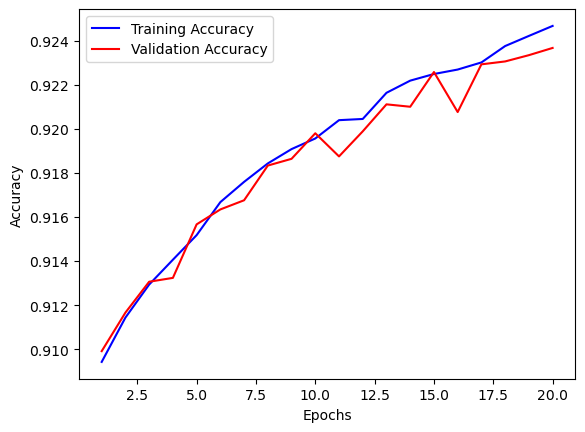

In [60]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         training_history.history['binary_accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 21, 1),
         training_history.history['val_binary_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
filename = f'./dataBase_models/modelisation3_simpleNeuralNetwork.h5'
model.save(filename)

In [ ]:
print(X_test.shape)
X_train.head()

In [61]:
# Prediction de l'échantillon de test
test_pred = model.predict(X_test)

# Evaluation du modèle
score = model.evaluate(X_test, pd.get_dummies(y_test, prefix=['Value']))

1788/1788 [==============================] - 3s 2ms/step - loss: 0.1844 - binary_accuracy: 0.9247


In [62]:
print(classification_report(y_test, test_pred[:,1]>0.5))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10645
           1       0.94      0.97      0.95     46552

    accuracy                           0.92     57197
   macro avg       0.89      0.86      0.87     57197
weighted avg       0.92      0.92      0.92     57197



In [ ]:
cnf_matrix = confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

### Architecture Simple (target = Notes)

In [ ]:
df = df_test.filter(like = 'vect')
                    
df = pd.concat([df,df_test[['Nombre_avis_publie','longCommentaire','longTitres','nb_Mots_Commentaire','nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre', 'Note']]],axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Note"), df['Note'], test_size=0.2, random_state=42)


In [ ]:
inputsN = Input(shape = X_train.shape[1], name = "input")

dense1N = Dense(units = 60, activation = "tanh",kernel_initializer ='normal', name = "dense_1")
dense2N = Dense(units = 5, activation = "softmax",kernel_initializer ='normal', name = "dense_2")

x=dense1N(inputsN)

outputsN=dense2N(x)

model2 = Model(inputs = inputsN, outputs = outputsN)

model2.summary()

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


training_history = model2.fit(X_train, tf.one_hot(y_train,depth=5),          # données d'entraînement
                             epochs = 20,               # nombre d'epochs
                             batch_size = 200,          # taille des batchs
                             validation_split = 0.2)



In [ ]:
import numpy
# Prediction de l'échantillon de test
test_pred = model2.predict(X_test)

# Evaluation du modèle
#score = model.evaluate(X_test, pd.get_dummies(y_test, prefix=['Value']))

print(classification_report(y_test, numpy.argmax(test_pred,axis=1)))

### Architecture LSTM:

In [ ]:

def LSTM_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(2, activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='binary_crossentropy',  metrics=["binary_accuracy"])
    # Early stopping and best model checkpoint parameters
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    # Train the model 
    history = model.fit(X_train, tf.one_hot(y_train, depth=2),
                        validation_split = 0.2,
                        epochs=200, verbose=0, callbacks=[es, mc])
    return history, model

In [5]:
df_lstm = pd.read_csv("./df_featEngin.csv")

# (a) Supprimer les caractères spéciaux, chiffres, valeurs manquantes et mettre le texte en minuscules.
df_lstm['Commentaire'] = df_lstm['Commentaire'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_lstm['Commentaire'] = df_lstm['Commentaire'].fillna('') 
df_lstm['Titres'] = df_lstm['Titres'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_lstm['Titres'] = df_lstm['Titres'].fillna('') 
#df_test = df_test.drop(columns=[])
df_test.head(10)

The default value of regex will change from True to False in a future version.
The default value of regex will change from True to False in a future version.


,index,Nombre_avis_publie,Note,Titres,Commentaire,Verifications,longCommentaire,longTitres,nb_Mots_Commentaire,nb_Mots_Titres,...,Titres_3grame_livraison_trop_longue,Titres_3grame_delai_livraison_trop,Titres_3grame_rapport_qualite_prix,Titres_3grame_livraison_rapide_conforme,Titres_3grame_livraison_peu_longue,Titres_3grame_livraison_rapide_prix,TextBlob_polarity_Commentaire,TextBlob_polarity_Titres,Saison_experience,Sentiment
0,0,1,5,je commande mes pneus de motos et de voitures,je commande mes pneus de motos et de voitures ...,1,215,45,31,9,...,0,0,0,0,0,0,0.271000,0.00,3,1
1,1,6,5,ne cherchez plus vos pneus allopneus le peut,bonjourle site est genial tres bien explique p...,1,315,45,48,8,...,0,0,0,0,0,0,0.400000,0.15,3,1
2,2,3,5,tout etait parfait,tout etait parfait timing parfait dans les dat...,1,227,18,36,3,...,0,0,0,0,0,0,0.391667,0.51,3,1
3,3,4,5,pneus dun tres bon rapport qualite,pneus dun tres bon rapport qualite prix les me...,1,157,36,22,6,...,0,0,0,0,0,0,0.607500,1.00,3,1
4,4,1,4,bon suivi de la commandeles questions,bon suivi de la commandeles questions sont imm...,1,218,39,34,6,...,0,0,0,0,0,0,0.133333,0.70,3,1
5,5,1,5,excellent service bien plus avantageux compare...,ce service sur place est d un grand secours ri...,1,276,62,48,8,...,0,0,0,0,0,0,0.202083,0.21,3,1
6,6,1,5,commande jusquau montage,la commande sur internet cest tres bien passee...,1,439,25,71,3,...,0,0,0,0,0,0,0.216923,0.00,3,1
7,7,4,5,excellent,ras le rapport qualite prix est tres correct t...,1,217,9,39,1,...,0,0,0,0,0,0,0.367143,0.50,3,1
8,8,3,5,fidele depuis de nombreuses annees j ai,fidele depuis de nombreuses annees j ai toujou...,1,112,40,19,7,...,0,0,0,0,0,0,0.282500,0.05,3,1
9,9,1,5,meilleur rapport qualite prix,ma ete recommande meilleur rapport qualite pri...,1,183,29,30,4,...,0,0,1,0,0,0,0.207500,0.53,3,1


In [6]:
# Define preprocessing function
stop_words = set(stopwords.words('french'))

def preprocess_text(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Apply FastText embeddings to each element in the Series
def get_text_embedding_lstm(text):
    preprocessed_text = preprocess_text(text)
    word_embeddings = [model_Ft.wv[word] for word in preprocessed_text if word in model_Ft.wv.key_to_index]

    if word_embeddings:
        text_embedding = word_embeddings  
    else:
        text_embedding = np.zeros((1,model_Ft.vector_size))  # Use zero vector if no embeddings found
    
    return text_embedding

In [8]:
df_lstm['embedding_Commentaire'] = df_lstm['Commentaire'].apply(get_text_embedding_lstm)
df_lstm['embedding_Titres'] = df_lstm['Titres'].apply(get_text_embedding_lstm)

In [9]:
print(df_lstm['Commentaire'][0])


from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have a list of vectorized sequences called 'vectorized_text'
padded_sequences = pad_sequences(df_lstm['embedding_Commentaire'], maxlen=50, padding='post', truncating='post')


je commande mes pneus de motos et de voitures depuis deja quelques anneesle site est simple et efficace loffre interessante le service de facturation et livraison est professionnels sans mauvaises surprisesmarc


In [ ]:
print(padded_sequences.shape)

In [10]:
Xlstm_train, Xlstm_test, ylstm_train, ylstm_test = train_test_split(padded_sequences, df_lstm['Sentiment'], test_size=0.2, random_state=42)

In [32]:
print(Xlstm_test.shape)
print(ylstm_test.shape)

x = Xlstm_test[0:1000,None,None].reshape(1000,-1)
y = ylstm_test[0:1000]

print(x.reshape(1000,50,300).shape)
print(y.shape)

#np.savetxt('./xTest_lstm.csv',x,delimiter=",")
#np.savetxt('./yTest_lstm.csv',y,delimiter=",")


(57197, 50, 300)
(57197,)
(1000, 50, 300)
(1000,)


In [ ]:
hist, model_lstm = LSTM_model(Xlstm_train,ylstm_train)

In [ ]:
print(hist.history.keys())
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 43, 1),
         hist.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 , 43, 1),
         hist.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

# Affichacccccccccccccccccccczzzzzzzzzzzzzzzzz6ge de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [ ]:
# Prediction de l'échantillon de test
test_pred = model_lstm.predict(Xlstm_test)

# Evaluation du modèle
score = model_lstm.evaluate(Xlstm_test, pd.get_dummies(ylstm_test, prefix=['Value']))

In [ ]:
print(classification_report(y_test, test_pred[:,1]>0.5))

In [ ]:
filename = f'./dataBase_models/modelisation3_lstm_BodyComment.h5'
model_lstm.save(filename)

### Architecture LSTM multi-Input:

In [ ]:
df_lstm = pd.read_csv("./df_featEngin.csv")

# (a) Supprimer les caractères spéciaux, chiffres, valeurs manquantes et mettre le texte en minuscules.
df_lstm['Commentaire'] = df_lstm['Commentaire'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_lstm['Commentaire'] = df_lstm['Commentaire'].fillna('') 
df_lstm['Titres'] = df_lstm['Titres'].str.replace('[^a-zA-Z\s]', '').str.lower()
df_lstm['Titres'] = df_lstm['Titres'].fillna('') 
#df_test = df_test.drop(columns=[])
df_lstm.head(10)

In [ ]:
#Padding:

df_lstm['embedding_Commentaire'] = df_lstm['Commentaire'].apply(get_text_embedding_lstm)
df_lstm['embedding_Titres'] = df_lstm['Titres'].apply(get_text_embedding_lstm)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have a list of vectorized sequences called 'vectorized_text'
padded_sequences = pad_sequences(df_lstm['embedding_Commentaire'], maxlen=50, padding='post', truncating='post')
padded_sequencesTitres = pad_sequences(df_lstm['embedding_Titres'], maxlen=10, padding='post', truncating='post')

In [ ]:
xtitre_train, xtitre_test, ytitre_train, ytitre_test = train_test_split(padded_sequencesTitres, df_lstm['Sentiment'], test_size=0.2, random_state=42)
xbody_train, xbody_test, ybody_train, ybody_test = train_test_split(padded_sequences, df_lstm['Sentiment'], test_size=0.2, random_state=42)
xMdata_train, xMdata_test, yMdata_train, yMdata_test = train_test_split(df_lstm[['Nombre_avis_publie','longCommentaire','longTitres','nb_Mots_Commentaire','nb_Mots_Titres', 'nb_majuscules_Commentaire',
       'nb_chiffres_Commentaire', 'nb_ponctuation_Commentaire',
       'nb_special_Commentaire', 'nb_majuscules_Titre', 'nb_chiffres_Titre',
       'nb_ponctuation_Titre', 'nb_special_Titre']], df_lstm['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Definition des modeles:

print(df_lstm['Titres'][0])
print(df_lstm['embedding_Titres'][0])

print(preprocess_text(df_lstm['Titres'][0]))

print(xbody_train.shape)
print(xtitre_train.shape)

#LSTM Body:
input_body = Input(shape=(300,))
lstm_body = LSTM(100, activation='tanh', input_shape=(xbody_train.shape[1], xbody_train.shape[2]))(input_body)
lstm_title = LSTM(100, activation='tanh', input_shape=(xtitre_train.shape[1], xtitre_train.shape[2]))
